# Checkpointing

Your task is to implement checkpointing for a MLP using NumPy.

You are free to use the implementation of a MLP and the backpropagation algorithm that you have developed during lab sessions.

The key takeaway from this task is that with checkpointing we can trade off the computational resources needed to compute the forward pass of the network for the memory requirement needed to perform a backward pass in the network, which is often a major bottleneck when training large networks. In plain english, we can slightly increase the time required for training our network to save some of our GPU's precious memory.

## What is checkpointing?

The aim of checkpointing is to save every $n$-th layer's (e.g. every 2-nd layer's) forward result (instead of saving every layer's forward result as in plain backpropagation) and use these checkpoints for recomputing the forward pass of the network upon doing a backward pass. Checkpoint layers are kept in memory after the forward pass, while the remaining activations are recomputed at most once. After being recomputed, the non-checkpoint layers are kept in memory until they are no longer required.

# What should be done

1. Take the implementation a MLP trained with backpropagation. Analyze the algorithm with respect to the memory that is used by the algorithm with respect to the number of hidden layers.

2. Implement a class NetworkWithCheckpointing that inherits from the Network class defined during lab sessions by:
    a) implementing a method `forward_between_checkpoints` that will recompute the forward pass of the network using one of the checkpointed layers
    b) override the method `backprop` to use only checkpointed layers and otherwise compute the activations using `forward_between_checkpoints` method and keep it in memory until no longer needed.

3. Train your network with checkpoinintg on MNIST. Compare running times and memory usage with respect to the network without checkpointing.


# Implement Checkpointing for a MLP

In [16]:
import random
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2022-11-18 14:51:45--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.52.160, 52.217.197.32, 54.231.161.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.52.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10,96M  8,32MB/s    in 1,3s    

2022-11-18 14:51:47 (8,32 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [3]:
# Let's read the mnist dataset

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

In [4]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

In [5]:
class Network(object):
    ######################################################################################
    ### Your Implementation of a MLP with backpropagation implemented during tutorials ###
    ######################################################################################
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a
    
    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate      
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)
            
        self.weights = [w-(eta/len(mini_batch[0]))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        delta_nabla_b = [np.zeros_like(p) for p in self.biases]
        delta_nabla_w = [np.zeros_like(p) for p in self.weights]
        
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        for i in range(self.num_layers - 2, -1, -1):
            dLdf = np.multiply(dLdg,np.multiply(gs[i + 1],1-gs[i + 1])) #dldf
            delta_nabla_w[i] = np.dot(dLdf, gs[i].T) # df/dw
            delta_nabla_b[i] = np.expand_dims(dLdf.sum(axis=1), 1)
            dLdg = np.dot(self.weights[i].T, dLdf)
        
        return (delta_nabla_b,delta_nabla_w)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))

Here, the backpropagation needs to store (n - 1, n is number of layers) gradients over biases and weights (their size depends on layer sizes), but aside from that, it also needs to store n vectors with values after activation.

In [6]:
class NetworkWithCheckpointing(Network):

    def __init__(self, sizes, checkpoint_every_nth_layer: int = 0, *args, **kwargs):
        super().__init__(sizes, *args, **kwargs)
        ##########################
        ### Your solution here ###
        ##########################
        self.checkpoint_every_nth_layer = checkpoint_every_nth_layer

    # get activations of layers with indices 
    # in (checkpoint_idx_start * self.checkpoint_every_nth_layer, layer_idx_end)
    # left exclusive, right exclusive
    def forward_between_checkpoints(self, a, checkpoint_idx_start, layer_idx_end):
        ##########################
        ### Your solution here ###
        ##########################
        assert(layer_idx_end >= 0)
        
        checkpoint_layer_idx = checkpoint_idx_start * self.checkpoint_every_nth_layer
        activations = []
        
        for b, w in zip(
            self.biases[checkpoint_layer_idx:layer_idx_end - 1],
            self.weights[checkpoint_layer_idx:layer_idx_end - 1]
        ):
            a = sigmoid(np.matmul(w, a) + b)
            activations.append(a)
            
        return activations
        

    def backprop(self, x, y):
        ##########################
        ### Your solution here ###
        ##########################
        delta_nabla_b = [np.zeros_like(p) for p in self.biases]
        delta_nabla_w = [np.zeros_like(p) for p in self.weights]
        
        g = x
        checkpoint_gs = [g]
        layers_since_checkpoint = 0
        for b, w in zip(self.biases, self.weights):
            layers_since_checkpoint += 1
            f = np.dot(w, g)+b
            g = sigmoid(f)
            if layers_since_checkpoint == self.checkpoint_every_nth_layer:
                checkpoint_gs.append(g)
                layers_since_checkpoint = 0

        prev_checkpoint_to_end = self.forward_between_checkpoints(checkpoint_gs[-1], len(checkpoint_gs) - 1, self.num_layers)
        chunk = [checkpoint_gs.pop()] + prev_checkpoint_to_end
        
        g = chunk.pop()
        dLdg = self.cost_derivative(g, y)
        
        for i in range(self.num_layers - 2, -1, -1):
            if not chunk:
                prev_checkpoint_to_now = self.forward_between_checkpoints(checkpoint_gs[-1], len(checkpoint_gs) - 1, self.checkpoint_every_nth_layer * len(checkpoint_gs))
                chunk = [checkpoint_gs.pop()] + prev_checkpoint_to_now
            dLdf = np.multiply(dLdg,np.multiply(g,1-g)) #dldf
            g = chunk.pop()
            delta_nabla_w[i] = np.dot(dLdf, g.T) # df/dw
            delta_nabla_b[i] = np.expand_dims(dLdf.sum(axis=1), 1)
            dLdg = np.dot(self.weights[i].T, dLdf)
        
        return (delta_nabla_b,delta_nabla_w)
        


If using checkpointing, backpropagation does not need to store every layer's after-activation values. First of all, it keeps $\frac{n}{\text{checkpoint_every_nth_layer}}$ values after activation and in addition, it computes values between two consecutive checkpoints if needed (there are $\text{checkpoint_every_nth_layer} - 1$ values after activation between two consecutive checkpoints), in addition to that during each iteration, it gets rid of one after-activation value.
With no checkpointing, backprop kept delta_nabla_b, delta_nabla_w and n after-activation layer values, here in the peak moment we keep delta_nabla_b, delta_nabla_w, $\frac{n}{\text{checkpoint_every_nth_layer}} + (\text{checkpoint_every_nth_layer} - 1)$after-activation layer values and it decreases.<br>
Example: if we have 15 layers, no checkpointing backprop keeps 15 after-activation layer values, 14 gradients over biases and 14 gradients over weights. With checkpointing every 3rd layer, it keeps 14 gradients over biases, 14 gradients over weights and at first $\frac{15}{3}$ checkpoint values + 2. During second iteration $\frac{15}{3}$  checkpoint values + 1, then $\frac{15}{3}$, then $\frac{15}{3} - 1 + 2$ and so on.<br>
In short, number of after-activation values we keep is <br># of layers between current layer and closest previous checkpoint + checkpoints_left$\leq \text{checkpoint_every_nth_layer} - 1 + \frac{n}{\text{checkpoint_every_nth_layer}}\leq n$<br> at all times.

When it comes to running time, it's worth noticing, that unfortunately we need to recompute every after-activation layer value that was not checkpointed, there are $n - \frac{n}{\text{checkpoint_every_nth_value}} = \frac{n(\text{checkpoint_every_nth_value} - 1)}{\text{checkpoint_every_nth_value}}$ values that need recomputing. Without checkpointing, for each value we only compute its forward pass once, now for $\frac{\text{checkpoint_every_nth_value} - 1}{\text{checkpoint_every_nth_value}}$ of them, it needs to be done twice.

In [7]:
timeit_values = []
epochs = 10

In [8]:
%%capture
np.random.seed(42)
network = Network([784, 100, 100, 100, 30, 30, 30,10])
x = %timeit -o network.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

In [9]:
%%capture
np.random.seed(42)
network2 = NetworkWithCheckpointing([784, 100, 100, 100, 30, 30, 30, 10], checkpoint_every_nth_layer=0)
x = %timeit -o network2.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

In [10]:
%%capture
np.random.seed(42)
network2 = NetworkWithCheckpointing([784, 100, 100, 100, 30, 30, 30, 10], checkpoint_every_nth_layer=1)
x = %timeit -o network2.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

In [11]:
%%capture
np.random.seed(42)
network2 = NetworkWithCheckpointing([784, 100, 100, 30, 30, 30, 10], checkpoint_every_nth_layer=2)
x = %timeit -o network2.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

In [12]:
%%capture
np.random.seed(42)
network2 = NetworkWithCheckpointing([784, 100, 100, 100, 30, 30, 30, 10], checkpoint_every_nth_layer=3)
x = %timeit -o network2.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

In [13]:
%%capture
np.random.seed(42)
network2 = NetworkWithCheckpointing([784, 100, 100, 100, 30, 30, 30, 10], checkpoint_every_nth_layer=4)
x = %timeit -o network2.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

In [14]:
%%capture
np.random.seed(42)
network2 = NetworkWithCheckpointing([784, 100, 100, 100, 30, 30, 30, 10], checkpoint_every_nth_layer=5)
x = %timeit -o network2.SGD((x_train, y_train), epochs=epochs, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
timeit_values.append(x)

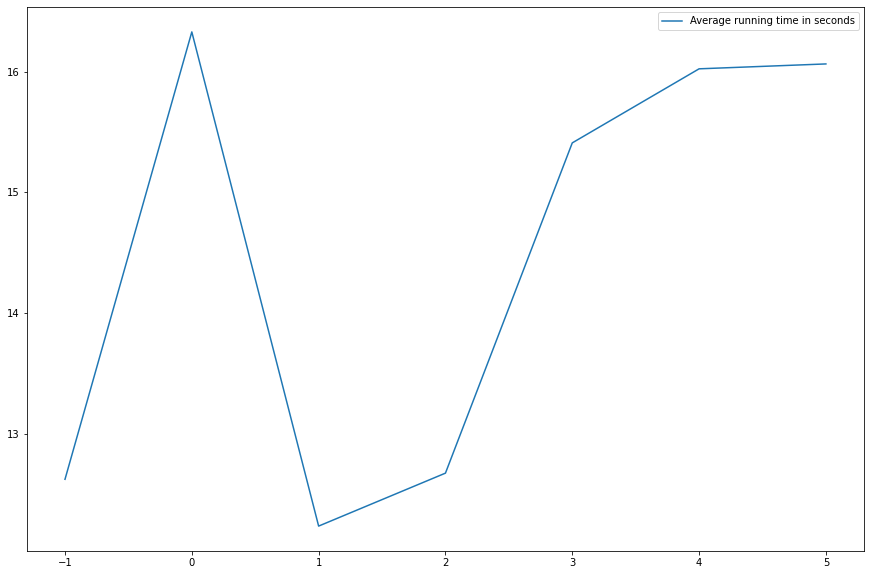

In [36]:
ys = [t.average for t in timeit_values]
xs = range(-1, 6)
plt.plot(xs, ys, label='Average running time in seconds')
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

It is interesting to see how running time is affected by checkpoint_every_nth_layer (-1 means we are using base version with no checkpointing).<br>
No checkpointing has a similar running time as checkpointing every 1 and 2 layer, and that is quite expected, no checkpointing is basically the same as checkointing every 1 layer, and checkpointing every 2 layer does not require much more computations.<br>
Checkpointing every 0 layer is basically no checkpointing at all, and calculating forward pass twice, that is why it's the longest.<br>
From checkpointing every 2 layer upwards, we can see that running time is increasing but looks like it might be stabilizing, that is because eventually if we would checkpoint every nth layer where n is number of layers or more, we would not be doing any checkpointing at all (same as n = 0).